In [1]:
import numpy as np
import pandas as pd
import scipy as sc

from importlib import reload
from time import time
import matplotlib

import utils

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [2]:
ptm_idr_df = pd.read_csv('ptm_idr.csv')
ptm_idr_df

,protein_id,AA,position,ac,ac_reg,ga,gl,gl_reg,m,m_reg,...,nAA_20_180_pae,nAA_24_180_nopae,nAA_24_180_pae,nAA_28_180_nopae,nAA_28_180_pae,protein_number,nAA_24_180_pae_smooth10,disordered,ordered,pred_disordered
0,O00151,K,22,1,0,0,0,0,0,0,...,37,81,48,110,64,20,65.904762,0.0,1.0,0
1,O00151,K,71,0,0,0,0,0,0,0,...,52,80,74,87,80,20,68.523810,0.0,1.0,0
2,O00151,K,87,0,0,0,0,0,1,0,...,8,98,12,139,19,20,34.238095,0.0,1.0,1
3,O00151,T,34,0,0,0,0,0,0,0,...,41,94,63,113,82,20,65.380952,0.0,1.0,0
4,O00168,S,82,0,0,0,0,0,0,0,...,14,45,16,56,19,21,13.761905,0.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10808,Q9Y6W3,S,697,0,0,0,0,0,0,0,...,53,82,70,109,84,3046,81.285714,0.0,1.0,0
10809,Q9Y6W3,S,700,0,0,0,0,0,0,0,...,57,91,78,112,92,3046,78.333333,0.0,1.0,0
10810,Q9Y6W6,K,380,0,0,0,0,0,0,0,...,35,112,55,185,79,3047,101.571429,0.0,1.0,0
10811,Q9Y6Y9,Y,131,0,0,0,0,0,0,0,...,63,103,85,120,107,3048,68.238095,0.0,1.0,0


In [65]:
reload(utils)
N = len(ptm_idr_df)
ns = np.logspace(np.log10(100), np.log10(N - 1000), num=10, base=10).astype(int)
n_trial = 1000
ptm_names = ['p', 'ub']
alpha = 0.1
grid_spacing = 5e-4
parallelize = False
print_every = 200

mu1maici_pxnxtx2 = np.zeros([len(ptm_names), ns.size, n_trial, 2])
mu1claci_pxnxtx2 = np.zeros([len(ptm_names), ns.size, n_trial, 2])
mu1cov_pxcxtx2 = np.zeros([len(ptm_names), ns.size, n_trial, 2])
mu0maici_pxnxtx2 = np.zeros([len(ptm_names), ns.size, n_trial, 2])
mu0claci_pxnxtx2 = np.zeros([len(ptm_names), ns.size, n_trial, 2])
mu0cov_pxcxtx2 = np.zeros([len(ptm_names), ns.size, n_trial, 2])
omaici_pxnxtx2 = np.zeros([len(ptm_names), ns.size, n_trial, 2])
oclaci_pxnxtx2 = np.zeros([len(ptm_names), ns.size, n_trial, 2])
ocov_pxcxtx2 = np.zeros([len(ptm_names), ns.size, n_trial, 2])

for p_idx, ptm_name in enumerate(ptm_names):
    for n_idx, n in enumerate(ns):
        
        t0 = time()
        print('PTM = {}, n = {}'.format(ptm_name, n))
        
        for t in range(n_trial):

            lab_idx = np.random.choice(len(ptm_idr_df), n, replace=False)
            result = utils.get_odds_ratio_betting_ci(
                ptm_idr_df, ptm_name, lab_idx, alpha, grid_spacing=grid_spacing,
                parallelize=parallelize, verbose=False, n_cores=n_cores
            )
            o, o_mai_ci, o_cla_ci, mu1, mu1_mai_ci, mu1_cla_ci, mu0, mu0_mai_ci, mu0_cla_ci = result

            # record results
            mu1maici_pxnxtx2[p_idx, n_idx, t] = mu1_mai_ci
            mu1claci_pxnxtx2[p_idx, n_idx, t] = mu1_cla_ci
            mu1cov_pxcxtx2[p_idx, n_idx, t, 0] = (mu1 >= mu1_mai_ci[0]) & (mu1 <= mu1_mai_ci[1])
            mu1cov_pxcxtx2[p_idx, n_idx, t, 1] = (mu1 >= mu1_cla_ci[0]) & (mu1 <= mu1_cla_ci[1])
            mu0maici_pxnxtx2[p_idx, n_idx, t] = mu0_mai_ci
            mu0claci_pxnxtx2[p_idx, n_idx, t] = mu0_cla_ci
            mu0cov_pxcxtx2[p_idx, n_idx, t, 0] = (mu0 >= mu0_mai_ci[0]) & (mu0 <= mu0_mai_ci[1])
            mu0cov_pxcxtx2[p_idx, n_idx, t, 1] = (mu0 >= mu0_cla_ci[0]) & (mu0 <= mu0_cla_ci[1])
            omaici_pxnxtx2[p_idx, n_idx, t] = o_mai_ci
            oclaci_pxnxtx2[p_idx, n_idx, t] = o_cla_ci
            ocov_pxcxtx2[p_idx, n_idx, t, 0] = (o >= o_mai_ci[0]) & (o <= o_mai_ci[1])
            ocov_pxcxtx2[p_idx, n_idx, t, 1] = (o >= o_cla_ci[0]) & (o <= o_cla_ci[1])
            
            if (t + 1) % print_every == 0:
                print('  Done with {} trials. {:d} s'.format(t + 1, int(time() - t0)))
            
        print('  Average model-assisted CI length: {:.2f}'.format(
            np.mean(omaici_pxnxtx2[p_idx, n_idx, :, 1] - omaici_pxnxtx2[p_idx, n_idx, :, 0])))
        print('  Average classical CI length: {:.2f}'.format(
            np.mean(oclaci_pxnxtx2[p_idx, n_idx, :, 1] - oclaci_pxnxtx2[p_idx, n_idx, :, 0])))
        print('  Model-assisted CI coverage: {:.2f}'.format(np.mean(ocov_pxcxtx2[p_idx, n_idx, :, 0])))
        print('  Classical CI coverage: {:.2f}'.format(np.mean(ocov_pxcxtx2[p_idx, n_idx, :, 1])))
        print('{:d} s'.format(int(time() - t0)))
        np.savez(
            'sampling-sites-wor-cis.npz',
            mu1maici_pxnxtx2=mu1maici_pxnxtx2,
            mu1claci_pxnxtx2=mu1claci_pxnxtx2,
            mu1cov_pxcxtx2=mu1cov_pxcxtx2,
            mu0maici_pxnxtx2=mu0maici_pxnxtx2,
            mu0claci_pxnxtx2=mu0claci_pxnxtx2,
            mu0cov_pxcxtx2=mu0cov_pxcxtx2,
            omaici_pxnxtx2=omaici_pxnxtx2,
            oclaci_pxnxtx2=oclaci_pxnxtx2,
            ocov_pxcxtx2=ocov_pxcxtx2
        )

PTM = p, n = 100


/home/clarafy/waterslides/model-assisted-inference/alphafold/utils.py:79: RuntimeWarning: divide by zero encountered in double_scalars
  o_ci = (ratio_mu1[0] / ratio_mu0[1], ratio_mu1[1] / ratio_mu0[0])


  Done with 200 trials. 118 s
  Done with 400 trials. 236 s
  Done with 600 trials. 355 s
  Done with 800 trials. 473 s
  Done with 1000 trials. 590 s
  Average model-assisted CI length: inf
  Average classical CI length: inf
  Model-assisted CI coverage: 1.00
  Classical CI coverage: 1.00
590 s
PTM = p, n = 166
  Done with 200 trials. 114 s
  Done with 400 trials. 229 s
  Done with 600 trials. 343 s
  Done with 800 trials. 458 s
  Done with 1000 trials. 574 s
  Average model-assisted CI length: inf
  Average classical CI length: 58.67
  Model-assisted CI coverage: 1.00
  Classical CI coverage: 0.99
574 s
PTM = p, n = 277
  Done with 200 trials. 118 s
  Done with 400 trials. 237 s
  Done with 600 trials. 355 s
  Done with 800 trials. 474 s
  Done with 1000 trials. 593 s
  Average model-assisted CI length: inf
  Average classical CI length: 6.74
  Model-assisted CI coverage: 1.00
  Classical CI coverage: 0.99
593 s
PTM = p, n = 461
  Done with 200 trials. 125 s
  Done with 400 trials. 2

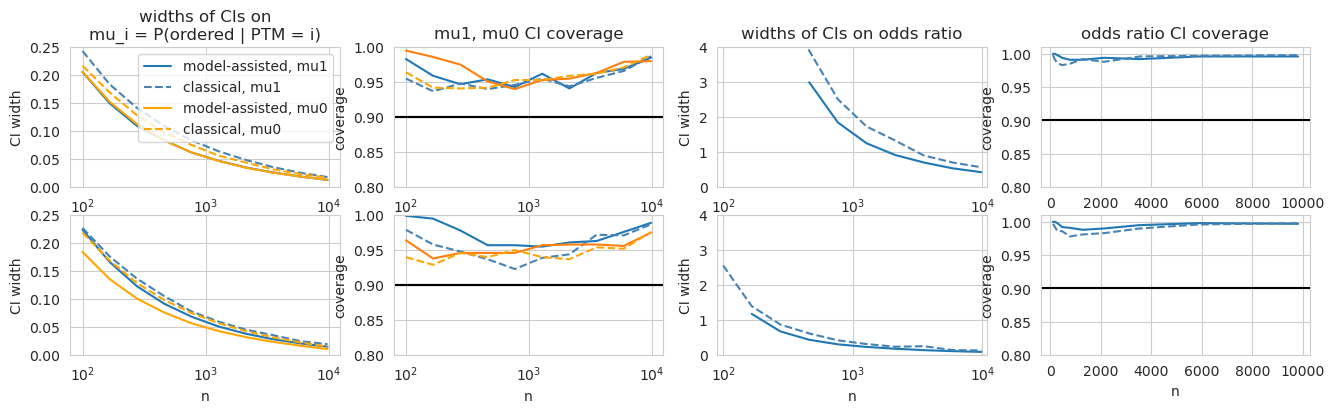

In [67]:
fig, axs = plt.subplots(len(ptm_names), 4, figsize=(16, len(ptm_names) * 2))
for p_idx, ptm_name in enumerate(ptm_names):
    
    # mu1
    mu1maicilen_n = np.mean(mu1maici_pxnxtx2[p_idx, :, :, 1] - mu1maici_pxnxtx2[p_idx, :, :, 0], axis=1)
    mu1clacilen_n = np.mean(mu1claci_pxnxtx2[p_idx, :, :, 1] - mu1claci_pxnxtx2[p_idx, :, :, 0], axis=1)
    axs[p_idx, 0].plot(ns, mu1maicilen_n, label='model-assisted, mu1')
    axs[p_idx, 0].plot(ns, mu1clacilen_n, c='steelblue', linestyle='--', label='classical, mu1')
    
    mu1maicicov_n = np.mean(mu1cov_pxcxtx2[p_idx, :, :, 0], axis=1)
    mu1clacicov_n = np.mean(mu1cov_pxcxtx2[p_idx, :, :, 1], axis=1)
    axs[p_idx, 1].plot(ns, mu1maicicov_n)
    axs[p_idx, 1].plot(ns, mu1clacicov_n, c='steelblue', linestyle='--')
    axs[p_idx, 1].set_ylim([1 - 2 * alpha, 1])
    axs[p_idx, 1].axhline(1 - alpha, c='k')
    
    # mu0
    mu0maicilen_n = np.mean(mu0maici_pxnxtx2[p_idx, :, :, 1] - mu0maici_pxnxtx2[p_idx, :, :, 0], axis=1)
    mu0clacilen_n = np.mean(mu0claci_pxnxtx2[p_idx, :, :, 1] - mu0claci_pxnxtx2[p_idx, :, :, 0], axis=1)
    axs[p_idx, 0].plot(ns, mu0maicilen_n, c='orange', label='model-assisted, mu0')
    axs[p_idx, 0].plot(ns, mu0clacilen_n, c='orange', linestyle='--', label='classical, mu0')
    
    mu0maicicov_n = np.mean(mu0cov_pxcxtx2[p_idx, :, :, 0], axis=1)
    mu0clacicov_n = np.mean(mu0cov_pxcxtx2[p_idx, :, :, 1], axis=1)
    axs[p_idx, 1].plot(ns, mu0maicicov_n)
    axs[p_idx, 1].plot(ns, mu0clacicov_n, c='orange', linestyle='--')
    axs[p_idx, 1].set_ylim([1 - 2 * alpha, 1])
    axs[p_idx, 1].axhline(1 - alpha, c='k')
    
    axs[p_idx, 0].set_xscale('log');
    axs[p_idx, 1].set_xscale('log');
    axs[p_idx, 0].set_ylabel('CI width');
    axs[p_idx, 1].set_ylabel('coverage');
    axs[p_idx, 0].set_ylim([0, 0.25]);
    
    
    # odds ratio
    omaicilen_n = np.mean(omaici_pxnxtx2[p_idx, :, :, 1] - omaici_pxnxtx2[p_idx, n_idx, :, 0], axis=1)
    oclacilen_n = np.mean(oclaci_pxnxtx2[p_idx, :, :, 1] - oclaci_pxnxtx2[p_idx, n_idx, :, 0], axis=1)
    axs[p_idx, 2].plot(ns, omaicilen_n, label='model-assisted, odds ratio')
    axs[p_idx, 2].plot(ns, oclacilen_n, c='steelblue', linestyle='--', label='classical, odds ratio')
    axs[p_idx, 2].set_xscale('log');
    axs[p_idx, 2].set_xlim([90, N]);
    axs[p_idx, 2].set_ylim([0, 4]);
    axs[p_idx, 2].set_ylabel('CI width');
    
    omaicicov_n = np.mean(ocov_pxcxtx2[p_idx, :, :, 0], axis=1)
    oclacicov_n = np.mean(ocov_pxcxtx2[p_idx, :, :, 1], axis=1)
    axs[p_idx, 3].plot(ns, omaicicov_n)
    axs[p_idx, 3].plot(ns, oclacicov_n, c='steelblue', linestyle='--')
    axs[p_idx, 3].set_ylim([1 - 2 * alpha, 1.01])
    axs[p_idx, 3].axhline(1 - alpha, c='k')
    axs[p_idx, 3].set_ylabel('coverage')
    
    
for i in range(4):
    axs[-1, i].set_xlabel('n');
axs[0, 0].set_title('widths of CIs on\nmu_i = P(ordered | PTM = i)');
axs[0, 1].set_title('mu1, mu0 CI coverage');
axs[0, 2].set_title('widths of CIs on odds ratio');
axs[0, 3].set_title('odds ratio CI coverage');
axs[0, 0].legend();